# Climate-related Topic Modelling

### Environment Setup: Libraries for Text Processing, Topic Modeling, Visualization, and Evaluation

We import all necessary packages, models, and utilities for the workflow, including tools for data handling, text preprocessing, topic modelling (LDA), sentence embedding, clustering, classification, and visualisation.

The libraries cover a range of functionalities:

- Pandas, NumPy, and collections: for data manipulation and statistics

- NLTK: for text normalization, tokenization, and stopword filtering

- Scikit-learn: for vectorization, topic modeling, clustering, and evaluation

- Gensim: for advanced LDA modeling and TF-IDF support

- pyLDAvis: for interactive topic model visualization

- SentenceTransformers and UMAP: for embedding-based semantic clustering and 2D projection

- Matplotlib: for custom visualizations including color maps and layout control

- Hugging Face Datasets: for loading the ClimateBERT sentiment dataset

- IPython Display: for rich output formatting in Jupyter environments

In [1]:
# Idempotent setup
import sys, subprocess, importlib
from importlib import import_module

def pip_run(args: list[str]):
    subprocess.check_call([sys.executable, "-m", "pip", *args])

def get_version(modname: str) -> str | None:
    try:
        m = import_module(modname)
        return getattr(m, "__version__", None)
    except Exception:
        return None

TORCH_VER = "2.3.1"
TRANSFORMERS_VER = "4.41.1"
SENT_TRANS_VER = "2.7.0"

USE_CUDA = False
CUDA_TAG = "cu121"  

def ensure_trio_idempotent():
    # 1) torch
    cur_torch = get_version("torch")
    if cur_torch != TORCH_VER:
        print(f"[setup] torch {cur_torch} -> {TORCH_VER}")
        if USE_CUDA:
            pip_run(["install", f"torch=={TORCH_VER}+{CUDA_TAG}", "--index-url",
                     f"https://download.pytorch.org/whl/{CUDA_TAG}"])
        else:
            pip_run(["install", f"torch=={TORCH_VER}", "--index-url",
                     "https://download.pytorch.org/whl/cpu"])
    else:
        print(f"[ok] torch=={TORCH_VER}")

    # 2) transformers
    cur_tf = get_version("transformers")
    if cur_tf != TRANSFORMERS_VER:
        print(f"[setup] transformers {cur_tf} -> {TRANSFORMERS_VER}")
        pip_run(["install", f"transformers=={TRANSFORMERS_VER}"])
    else:
        print(f"[ok] transformers=={TRANSFORMERS_VER}")

    # 3) sentence-transformers
    cur_st = get_version("sentence_transformers")
    if cur_st != SENT_TRANS_VER:
        print(f"[setup] sentence-transformers {cur_st} -> {SENT_TRANS_VER}")
        pip_run(["install", f"sentence-transformers=={SENT_TRANS_VER}"])
    else:
        print(f"[ok] sentence-transformers=={SENT_TRANS_VER}")

ensure_trio_idempotent()

# Install packages not present in the environment
def install_if_missing(packages):
    """
    Install packages by their pip name only if the corresponding import name is not importable.
    `packages` is a dict mapping pip package name -> python import name.
    """
    for pip_name, import_name in packages.items():
        try:
            importlib.import_module(import_name)   
        except ImportError:
            print(f"Installing missing package: {pip_name}")
            subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])

required_packages = {
    'pandas': 'pandas',                                # DataFrames and data analysis
    'numpy': 'numpy',                                  # Numeric arrays and linear algebra
    'matplotlib': 'matplotlib',                        # Plotting
    'seaborn': 'seaborn',                              # Statistical visualization
    'nltk': 'nltk',                                    # NLP utilities (tokenization, stopwords, etc.)
    'scikit-learn': 'sklearn',                         # ML algorithms and metrics
    'gensim': 'gensim',                                # Topic modeling (LDA, TF-IDF) and corpus tools
    'pyLDAvis': 'pyLDAvis',                            # Interactive LDA visualizations
    'umap-learn': 'umap',                              # Dimensionality reduction for visualization
    'datasets': 'datasets',                            # HuggingFace datasets loader
    'ipython': 'IPython'                               # Rich Jupyter display utilities
}

# Perform installation if any package is missing
install_if_missing(required_packages)                  # Install only those not importable

# Data Handling and Utilities
import pandas as pd               # Provides data structures and data analysis tools
import numpy as np                # Supports large, multi-dimensional arrays and matrices
import re                         # Enables pattern matching using regular expressions
from collections import Counter   # Implements specialized container datatypes

# Controls warning messages
import warnings                   # Controls warnings behavior
warnings.filterwarnings("ignore") # Suppress warnings for cleaner output

# Visualization Libraries
import matplotlib.pyplot as plt                             # Main plotting library
import seaborn as sns                                       # Statistical data-visualization library
from matplotlib.patches import Patch                        # For creating custom legend patches
from matplotlib.colors import ListedColormap, BoundaryNorm  # For custom colormap and normalization
from matplotlib.ticker import MaxNLocator                   # Ensures integer ticks on axes

# NLP and Text Preprocessing
import nltk                               # Provides tools for text processing
from nltk.corpus import stopwords         # Supplies common stop words for filtering
from nltk.stem import WordNetLemmatizer   # Performs lemmatization (reducing words to base forms)
from nltk.tokenize import word_tokenize   # Splits text into individual words

# Topic Modeling (LDA)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # Converts text into BoW / TF-IDF features
from sklearn.decomposition import LatentDirichletAllocation                   # Performs LDA (sklearn)

from gensim import corpora                        # Constructs dictionary and corpus
from gensim.models import LdaModel, TfidfModel    # LDA and TF-IDF (Gensim)

import pyLDAvis                                   # Interactive visualizations of LDA
import pyLDAvis.gensim_models as gensimvis        # Adapter for Gensim-based topic models

# Sentence Embeddings and Clustering
from sentence_transformers import SentenceTransformer      # Pretrained transformer-based sentence embeddings
from sklearn.cluster import KMeans                         # Clusters high-dimensional embeddings using K-Means
from umap import UMAP                                      # Dimensionality reduction for visualization of embeddings

# Classification and Evaluation
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix    # Evaluates classification performance

# Dataset Loading (HuggingFace)
from datasets import load_dataset                                         # Loads benchmark datasets

# Jupyter Display Utilities
from IPython.display import display, HTML                                 # Enables formatted output display in Jupyter notebooks

[setup] torch 2.3.1+cpu -> 2.3.1
[ok] transformers==4.41.1
[ok] sentence-transformers==2.7.0


### Setup: random seeds

In [2]:
import torch
import random
import numpy as np

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    try:
        torch.default_generator.manual_seed(seed)
    except Exception:
        pass
    try:
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
    except Exception:
        pass
    if hasattr(torch.backends, "cudnn"):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

random_seed = 42
set_seed(random_seed)

print("Random seed:", random_seed)
print("PyTorch seed:", torch.default_generator.initial_seed())

Random seed: 42
PyTorch seed: 42


### Topic Modeling and Semantic Classification for Climate-Related Risks and Opportunities

In this task, we aim to identify themes associated with climate-related risks and opportunities in the ClimateBERT sentiment dataset by combining traditional topic modeling and modern semantic embedding techniques. We begin by preprocessing the dataset to focus on two sentiment classes (excluding neutral) and apply standard NLP steps such as lowercasing, tokenization, stopword removal, and lemmatization.

To extract latent topics, we apply Latent Dirichlet Allocation (LDA) with two vectorization strategies: count-based and TF-IDF. We train models with different topic numbers (5 and 10) and compare their outputs. The top keywords for each topic are extracted, and we perform semantic classification using a sentence embedding model (all-MiniLM-L6-v2) by computing cosine similarity between each topic and predefined reference sentences representing risk and opportunity. This allows us to map unsupervised topics to interpretable climate sentiment classes.

To complement the LDA analysis, we apply K-Means clustering directly to sentence embeddings of the preprocessed documents to capture semantic patterns not constrained by term co-occurrence. Clusters are again labeled using similarity to the same reference sentences. We summarize the results in a structured table with top keywords, representative snippets, and assigned labels, and visualize the semantic space using UMAP for dimensionality reduction.

#### Step 1: Dataset Loading, Filtering, and Text Preprocessing

In the first step, we load and preprocess the ClimateBERT sentiment dataset from the Hugging Face Datasets library in preparation for a binary text classification task.

We Load the full dataset and splitting it into training and validation sets using an 80/20 ratio. To simplify the task and focus on more clearly defined sentiment categories, we filter the dataset to retain only two classes: risk (label 0) and opportunity (label 2), excluding the neutral class.

After consolidating the data into a single DataFrame, we apply a custom text preprocessing pipeline. Each document is converted to lowercase, tokenized, stripped of stopwords and punctuation, and then lemmatized using NLTK’s WordNetLemmatizer. The resulting tokens are reassembled into clean, informative text strings suitable for downstream modeling or vectorization.

In [3]:
# Set the random seed for reproducibility
set_seed(random_seed)

# Import libraries for dataset logging control
import os
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"
os.environ["TQDM_DISABLE"] = "1"

from datasets.utils.logging import disable_progress_bar, set_verbosity_error
disable_progress_bar()
set_verbosity_error()

# Load the full ClimateBERT dataset from Hugging Face into memory
dataset = load_dataset("climatebert/climate_sentiment", split="train", cache_dir="./data_cache")

# Split the dataset into training and validation sets using an 80/20 ratio
splits = dataset.train_test_split(test_size=0.2, seed=random_seed)
train_dataset = splits["train"]
val_dataset = splits["test"]

# Convert the text and label fields from both subsets into NumPy arrays
train_texts = np.array(train_dataset["text"])
train_labels = np.array(train_dataset["label"])
val_texts = np.array(val_dataset["text"])
val_labels = np.array(val_dataset["label"])

# Merge the training and validation data into a single DataFrame for unified preprocessing
df_all = pd.DataFrame({
    "text": list(train_texts) + list(val_texts),
    "label": list(train_labels) + list(val_labels)
})

# Filter the dataset to retain only documents labeled as "risk" (0) or "opportunity" (2)
df_filtered = df_all[df_all["label"].isin([0, 2])].copy()

# Download required NLTK resources for tokenization and lemmatization
nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("wordnet", quiet=True)

# Initialize the WordNet lemmatizer and load English stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# Define a text preprocessing function
# Steps: lowercase, tokenize, remove punctuation/stopwords/short tokens, lemmatize, and rejoin
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    cleaned_tokens = []
    for tok in tokens:
        if len(tok) > 1 and tok.isalpha() and tok not in stop_words:
            cleaned_tokens.append(lemmatizer.lemmatize(tok))
    return " ".join(cleaned_tokens)

# Apply the preprocessing function to all filtered documents
df_filtered["processed_text"] = df_filtered["text"].apply(preprocess_text)

#### Step 2: Topic Modeling with Latent Dirichlet Allocation (LDA) on Preprocessed Climate Sentiment Texts

In this step, we explore the latent thematic structure of climate-related texts labeled as risk or opportunity using Latent Dirichlet Allocation (LDA).
We begin by constructing two types of document-term matrices from the preprocessed corpus: one using raw term counts (CountVectorizer) and another using TF-IDF-weighted terms (TfidfVectorizer), both with basic frequency-based filtering (min_df=2, max_df=0.9) to remove rare and overly common terms.

We then train three LDA models to discover latent topics in the corpus:

- A 5-topic model using the count-based matrix

- A 10-topic model using the same count-based matrix

- A 5-topic model using the TF-IDF-based matrix

These models are used to uncover recurring lexical patterns that may characterize the risk and opportunity categories. To interpret the results, we define a helper function to print the top-N most representative words for each topic, thereby offering insight into the underlying semantic structure captured by each LDA configuration.

This analysis helps illuminate how unsupervised topic models group recurring ideas within the dataset and allows us to compare the influence of different vectorization methods and topic numbers on the interpretability of extracted topics.

In [4]:
# Set random seed
set_seed(random_seed)

# Construct document-term matrix using raw term counts with basic frequency filtering
count_vectorizer = CountVectorizer(min_df=2, max_df=0.9)
X_counts = count_vectorizer.fit_transform(df_filtered["processed_text"])
feature_names_count = count_vectorizer.get_feature_names_out()

# Construct document-term matrix using TF-IDF weights with the same filtering parameters
tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.9)
X_tfidf = tfidf_vectorizer.fit_transform(df_filtered["processed_text"])
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()

# Train Latent Dirichlet Allocation (LDA) topic model on count-based document-term matrix (5 topics)
lda_5 = LatentDirichletAllocation(n_components=5, random_state=random_seed)
lda_5.fit(X_counts)

# Train LDA model on the same count-based matrix but with more topics (10 topics)
lda_10 = LatentDirichletAllocation(n_components=10, random_state=random_seed)
lda_10.fit(X_counts)

# Train LDA model on TF-IDF-based document-term matrix (5 topics)
lda_5_tfidf = LatentDirichletAllocation(n_components=5, random_state=random_seed)
lda_5_tfidf.fit(X_tfidf)

# Define a helper function to extract and print top-n words for each topic
def print_topics(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[::-1][:n_top_words]  # Indices of top words by probability
        top_words = [feature_names[i] for i in top_indices]  # Map indices to feature names
        print(f"Topic {idx + 1} top words: {', '.join(top_words)}")

# Print discovered topics from the count-based LDA model with 5 topics
print("\n" + "="*100)
print("LDA with CountVectorizer (5 topics):\n")
print_topics(lda_5, feature_names_count)

# Print discovered topics from the TF-IDF-based LDA model with 5 topics
print("\n" + "="*100)
print("LDA with TF-IDF (5 topics):\n")
print_topics(lda_5_tfidf, feature_names_tfidf)

# Print discovered topics from the count-based LDA model with 10 topics
print("\n" + "="*100)
print("LDA with CountVectorizer (10 topics):\n")
print_topics(lda_10, feature_names_count)
print("\n" + "="*100)


LDA with CountVectorizer (5 topics):

Topic 1 top words: risk, climate, change, impact, may, physical, business, group, management, environmental
Topic 2 top words: risk, climate, change, impact, could, increase, cost, may, physical, scenario
Topic 3 top words: energy, million, project, investment, emission, fund, renewable, power, carbon, green
Topic 4 top words: investment, oil, social, portfolio, asset, environmental, impact, fund, gas, real
Topic 5 top words: energy, climate, sustainable, billion, carbon, development, finance, company, business, goal

LDA with TF-IDF (5 topics):

Topic 1 top words: risk, climate, change, impact, may, business, energy, investment, physical, carbon
Topic 2 top words: plant, http, cement, education, supplier, fund, branch, power, catalyst, regular
Topic 3 top words: wind, solar, energy, farm, renewable, project, million, generation, divested, power
Topic 4 top words: million, bond, project, green, electricity, gas, july, finance, approximately, one
T

#### Step 3: Topic Modeling and Visualization Using Gensim LDA and pyLDAvis

In this step, we apply Gensim’s implementation of Latent Dirichlet Allocation (LDA) to uncover latent topics in the filtered climate sentiment dataset and visualize the results using pyLDAvis.
We begin by preparing the input data, where preprocessed documents are tokenized and transformed into a bag-of-words (BoW) representation using a dictionary of unique terms. This BoW corpus serves as input to two LDA models trained with different numbers of topics (5 and 10), enabling a comparative analysis of topic granularity.

Additionally, we generate a TF-IDF-weighted version of the corpus using Gensim’s TfidfModel and train a third LDA model with 5 topics to explore the effect of alternative term weighting on topic structure. 

To enhance interpretability, we use pyLDAvis to create interactive visualizations of the learned topics, showing both topic-term distributions and inter-topic distances in a two-dimensional space. Each model’s visualization is saved as an HTML file for further exploration, inclusion in reports, or comparative evaluation across vectorization schemes and topic counts.

In [5]:
# Set random seed
set_seed(random_seed)

# Prepare the preprocessed documents as lists of tokens for LDA modeling
texts = df_filtered["processed_text"].tolist()
tokenized_texts = [doc.split() for doc in texts]

# Create a dictionary that maps each unique word to an ID
# Generate a bag-of-words (BoW) representation for each document
dictionary = corpora.Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Train a Gensim LDA model on the BoW corpus with 5 topics
lda_5_gensim = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=random_seed, passes=10)

# Train a Gensim LDA model with 10 topics for comparative analysis
lda_10_gensim = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=random_seed, passes=10)

# Apply TF-IDF transformation to the BoW corpus for alternative topic modeling
tfidf_model = TfidfModel(corpus)
corpus_tfidf = tfidf_model[corpus]

# Train an LDA model on the TF-IDF weighted corpus (5 topics)
lda_5_gensim_tfidf = LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5, random_state=random_seed, passes=10)

# Prepare interactive pyLDAvis visualizations for each of the trained models
# These visualizations provide interpretable topic-term distributions and inter-topic distances
vis_lda_5 = gensimvis.prepare(lda_5_gensim, corpus, dictionary)
vis_lda_10 = gensimvis.prepare(lda_10_gensim, corpus, dictionary)
vis_lda_5_tfidf = gensimvis.prepare(lda_5_gensim_tfidf, corpus_tfidf, dictionary)

# Save each visualization to an HTML file for further exploration or inclusion in a report
pyLDAvis.save_html(vis_lda_5, "lda5_gensim_pyldavis.html")
pyLDAvis.save_html(vis_lda_10, "lda10_gensim_pyldavis.html")
pyLDAvis.save_html(vis_lda_5_tfidf, "lda5_gensim_tfidf_pyldavis.html")

#### Step 4: Semantic Classification of LDA Topics Using Sentence Embeddings

In this step, we perform semantic interpretation and classification of topics discovered via LDA by leveraging dense vector representations from a SentenceTransformer model.
We begin by defining two reference sentences that represent the semantic intent of the target classes: risk and opportunity. These references are embedded using a compact pre-trained model (all-MiniLM-L6-v2) to serve as anchor points in the semantic space.

For each LDA model (trained using both count-based and TF-IDF vectorizers with different topic numbers), we extract the top-N keywords per topic. These keywords are concatenated into pseudo-sentences, which are then embedded using the same sentence embedding model.

To assign a class label to each topic, we compute cosine similarity between the topic embedding and each reference embedding. A topic is classified as RISK or OPPORTUNITY based on which reference it is semantically closer to in vector space.

In [6]:
# Define reference sentences that semantically represent the two target classes: risk and opportunity
reference_risk = "This topic is about climate-related physical or financial risk."
reference_opportunity = "This topic is about climate-related investment or opportunity."

# Load a compact SentenceTransformer model for embedding short text fragments and topic keywords
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Encode the reference sentences into dense vector representations
risk_vector = embedding_model.encode(reference_risk)
opportunity_vector = embedding_model.encode(reference_opportunity)

# Define a function to compute cosine similarity between two embedding vectors
def cosine_similarity(vec_a, vec_b):
    return np.dot(vec_a, vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

# Define a helper function to extract the top-n words for each topic in a trained LDA model
def extract_top_words_lda(lda_model, feature_names, n_top=5):
    topics_top_words = []
    for idx, topic in enumerate(lda_model.components_):
        top_indices = topic.argsort()[::-1][:n_top]          # Identify indices of top words
        top_terms = [feature_names[i] for i in top_indices]  # Map indices to words
        topics_top_words.append((idx, top_terms))            # Store topic ID and top words
    return topics_top_words

# Classify each LDA topic by comparing its top words to the risk/opportunity reference embeddings
def classify_topics_with_embeddings(topics_top_words):
    for topic_id, top_words in topics_top_words:
        topic_sentence = " ".join(top_words)                     # Combine top words into a pseudo-sentence
        topic_vector = embedding_model.encode(topic_sentence)    # Encode the sentence
        sim_risk = cosine_similarity(topic_vector, risk_vector)  # Compare with risk reference
        sim_opportunity = cosine_similarity(topic_vector, opportunity_vector)  # Compare with opportunity reference
        # Assign topic to the most similar reference class
        if sim_risk > sim_opportunity:
            classification = "RISK"
        else:
            classification = "OPPORTUNITY"
        # Display the topic classification result
        print(f"Topic {topic_id+1}: {top_words} → classified as {classification}")

# Extract the top keywords per topic from each trained LDA model for downstream classification
# Topics from LDA with CountVectorizer (5 topics)
topics_5_count = extract_top_words_lda(lda_5, feature_names_count, n_top=5)

# Topics from LDA with CountVectorizer (10 topics)
topics_10_count = extract_top_words_lda(lda_10, feature_names_count, n_top=5)

# Topics from LDA with TF-IDF vectorizer (5 topics)
topics_5_tfidf = extract_top_words_lda(lda_5_tfidf, feature_names_tfidf, n_top=5)

# Print topics from the LDA (CountVectorizer, 5 topics) model
print("\nLDA (CountVectorizer, 5 topics)")
classify_topics_with_embeddings(topics_5_count)

# Print topics from the LDA (TF-IDF, 5 topics) model
print("\nLDA (TF-IDF, 5 topics)")
classify_topics_with_embeddings(topics_5_tfidf)

# Print topics from the LDA (CountVectorizer, 10 topics) model
print("\nLDA (CountVectorizer, 10 topics)")
classify_topics_with_embeddings(topics_10_count)


LDA (CountVectorizer, 5 topics)
Topic 1: ['risk', 'climate', 'change', 'impact', 'may'] → classified as RISK
Topic 2: ['risk', 'climate', 'change', 'impact', 'could'] → classified as RISK
Topic 3: ['energy', 'million', 'project', 'investment', 'emission'] → classified as OPPORTUNITY
Topic 4: ['investment', 'oil', 'social', 'portfolio', 'asset'] → classified as OPPORTUNITY
Topic 5: ['energy', 'climate', 'sustainable', 'billion', 'carbon'] → classified as OPPORTUNITY

LDA (TF-IDF, 5 topics)
Topic 1: ['risk', 'climate', 'change', 'impact', 'may'] → classified as RISK
Topic 2: ['plant', 'http', 'cement', 'education', 'supplier'] → classified as OPPORTUNITY
Topic 3: ['wind', 'solar', 'energy', 'farm', 'renewable'] → classified as OPPORTUNITY
Topic 4: ['million', 'bond', 'project', 'green', 'electricity'] → classified as OPPORTUNITY
Topic 5: ['power', 'energy', 'million', 'project', 'renewable'] → classified as OPPORTUNITY

LDA (CountVectorizer, 10 topics)
Topic 1: ['risk', 'climate', 'chan

#### Step 5: Structured Semantic Classification and Visualization of LDA Topics

In this step, we formalize the semantic classification of LDA topics by computing similarity to reference class embeddings (risk vs. opportunity) and organizing the results into a structured and styled table for clear interpretation.
We define a reusable function that extracts the top-N keywords from each topic in a trained LDA model, constructs a pseudo-sentence by concatenating those keywords, and embeds the sentence using a pre-trained SentenceTransformer model (all-MiniLM-L6-v2). The resulting topic embedding is then compared to reference embeddings representing risk and opportunity using cosine similarity. Each topic is assigned to the class it is most semantically similar to.

We apply this classification method across three LDA configurations:

- LDA (CountVectorizer, 5 topics)

- LDA (TF-IDF, 5 topics)

- LDA (CountVectorizer, 10 topics)

The classification results—including the topic label, keywords, model configuration, and assigned semantic class—are collected into a unified DataFrame. 

To improve interpretability, we use pandas styling to highlight model boundaries with bottom borders and enforce consistent visual formatting. The final styled table enables comparative inspection of topics across models and aids in identifying which configurations most clearly differentiate between climate-related risk and opportunity themes.

In [7]:
# Define a function that classifies LDA topics using semantic similarity and stores the results in a DataFrame
def classify_topics_to_df(lda_model, feature_names, model_label, n_top=5):
    topics_top_words = []
    for idx, topic_vec in enumerate(lda_model.components_):
        # Identify the top-n most probable words for the current topic
        top_indices = topic_vec.argsort()[::-1][:n_top]
        top_terms = [feature_names[i] for i in top_indices]
        topics_top_words.append((idx, top_terms))

    records = []
    for topic_id, top_words in topics_top_words:
        # Convert top topic keywords into a single sentence
        topic_sentence = " ".join(top_words)
        # Embed the sentence using a pre-trained sentence-transformer model
        topic_vector = embedding_model.encode(topic_sentence)
        # Compute similarity with reference embeddings for risk and opportunity
        sim_risk = cosine_similarity(topic_vector, risk_vector)
        sim_opportunity = cosine_similarity(topic_vector, opportunity_vector)
        # Assign topic to the most semantically similar class
        classification = "RISK" if sim_risk > sim_opportunity else "OPPORTUNITY"

        # Store topic metadata and classification result
        records.append({
            "Model": model_label,
            "Topic": f"Topic {topic_id + 1}",
            "Keywords": ", ".join(top_words) + ",...",
            "Classification": classification
        })

    return pd.DataFrame(records)

# Generate classification results for each LDA model (5-topic and 10-topic variants)
df_5_count = classify_topics_to_df(lda_5, feature_names_count, "LDA (CountVectorizer, 5 topics)", n_top=5)
df_5_tfidf = classify_topics_to_df(lda_5_tfidf, feature_names_tfidf, "LDA (TF-IDF, 5 topics)", n_top=5)
df_10_count = classify_topics_to_df(lda_10, feature_names_count, "LDA (CountVectorizer, 10 topics)", n_top=5)

# Combine all classification results into a single DataFrame for visualization
df_topics_all = pd.concat([df_5_count, df_5_tfidf, df_10_count], ignore_index=True)

# Identify row indices where visual row borders should be inserted (after each model block)
split_indices = [len(df_5_count)-1, len(df_5_count)+len(df_5_tfidf)-1, len(df_topics_all)-1]

# Define a styling function that adds bottom borders at specified row indices
def apply_borders(row):
    idx = row.name
    border_style = '1px solid black'
    style = [''] * len(row)
    if idx in split_indices:
        style = [f'border-bottom: {border_style}'] * len(row)
    return style

# Apply table style
styled_df = df_topics_all.style \
    .set_table_styles([
        {'selector': 'table', 'props': [('border', '1px solid black'), ('border-collapse', 'collapse')]},
        {'selector': 'th', 'props': [
            ('text-align', 'left'),
            ('border-top', '1px solid black'),
            ('border-bottom', '1px solid #999999'),
            ('border-right', '1px solid black'),
            ('border-left', '1px solid black')
        ]},
        {'selector': 'td', 'props': [
            ('text-align', 'left'),
            ('border-right', '1px solid black'),
            ('border-left', '1px solid black')
        ]}
    ]) \
    .set_properties(**{'text-align': 'left'}) \
    .apply(apply_borders, axis=1) \
    .hide(axis='index') \
    .set_properties(subset=["Topic", "Classification"], **{"font-weight": "bold"}) \
    .set_properties(**{"font-size": "14px"})

# Print the DataFrame
display(styled_df)

Model,Topic,Keywords,Classification
"LDA (CountVectorizer, 5 topics)",Topic 1,"risk, climate, change, impact, may,...",RISK
"LDA (CountVectorizer, 5 topics)",Topic 2,"risk, climate, change, impact, could,...",RISK
"LDA (CountVectorizer, 5 topics)",Topic 3,"energy, million, project, investment, emission,...",OPPORTUNITY
"LDA (CountVectorizer, 5 topics)",Topic 4,"investment, oil, social, portfolio, asset,...",OPPORTUNITY
"LDA (CountVectorizer, 5 topics)",Topic 5,"energy, climate, sustainable, billion, carbon,...",OPPORTUNITY
"LDA (TF-IDF, 5 topics)",Topic 1,"risk, climate, change, impact, may,...",RISK
"LDA (TF-IDF, 5 topics)",Topic 2,"plant, http, cement, education, supplier,...",OPPORTUNITY
"LDA (TF-IDF, 5 topics)",Topic 3,"wind, solar, energy, farm, renewable,...",OPPORTUNITY
"LDA (TF-IDF, 5 topics)",Topic 4,"million, bond, project, green, electricity,...",OPPORTUNITY
"LDA (TF-IDF, 5 topics)",Topic 5,"power, energy, million, project, renewable,...",OPPORTUNITY


#### Step 6: Semantic Clustering of Climate-Related Documents Using Transformer Embeddings

In this step, we apply semantic clustering to the preprocessed climate sentiment documents using transformer-based sentence embeddings and K-Means clustering.
We first load a compact pre-trained model (all-MiniLM-L6-v2) from the SentenceTransformers library to encode each document into a dense vector that captures its contextual meaning. These embeddings provide a high-dimensional representation of semantic content beyond keyword frequency, enabling clustering based on meaning rather than surface-level co-occurrence.

We then apply K-Means clustering to the document embeddings, specifying k = 5 clusters to uncover latent semantic groupings within the dataset. Each document is assigned to a cluster, and labels are stored in the DataFrame for further inspection.

To qualitatively assess the coherence of each cluster, we print representative samples from each group. This allows us to explore whether the clusters correspond to meaningful and distinguishable themes related to climate risk or opportunity, thereby offering an alternative view of topic structure that complements LDA-based approaches.

In [8]:
# Set random seed
set_seed(random_seed)

# Load a pretrained sentence-transformers model to generate semantic embeddings for documents
# This model encodes each document into a dense vector capturing its contextual meaning
embedder = SentenceTransformer("all-MiniLM-L6-v2")

# Extract the list of preprocessed documents from the filtered DataFrame
docs = df_filtered["processed_text"].tolist()

# Generate a fixed-size embedding for each document using the loaded transformer model
# The resulting matrix has shape (n_documents, embedding_dim)
embeddings = embedder.encode(docs, show_progress_bar=True)

# Apply K-Means clustering to the document embeddings to group them into k semantic clusters
# This clustering represents topics derived from vector similarity rather than word co-occurrence
k = 5
kmeans_model = KMeans(n_clusters=k, random_state=random_seed)
kmeans_model.fit(embeddings)
cluster_labels = kmeans_model.labels_

# Assign the cluster label to each document (1-based indexing for readability)
df_filtered["cluster"] = cluster_labels + 1

# Print a small sample of documents from each cluster to inspect topic coherence or dominant themes
for cluster_id in range(1, k + 1):
    cluster_slice = df_filtered[df_filtered["cluster"] == cluster_id]
    print(f"\nCluster {cluster_id}:")
    print(cluster_slice["processed_text"].head(3).values)

Batches:   0%|          | 0/19 [00:00<?, ?it/s]


Cluster 1:
['invested total million energy efficiency program adheres aneel regulatory guideline project developed saved approximately mwh energy enough serve around residential customer one year saved volume also represents emission ton co'
 'australia largest corporate purchaser electricity renewable project connected grid project specific agreement output project go total grid pool rather directly facility agreement play role providing investment certainty enable project proceed grid increase proportion renewable energy due agreement u others power flow facility grid also becomes greener project agreement including murra warra wind farm emerald solar park generate renewable energy equivalent energy consumption household continue build work invest renewable energy generation'
 'low carbon fuel standard existing proposed environmental legislation regulation developed certain state canadian province canadian federal government member european union regulating carbon fuel standard coul

#### Step 7: Interpretable Semantic Classification and Visualization of Embedding-Based Clusters

In this step, we assign interpretable semantic labels to document clusters derived from embedding-based K-Means clustering, and visualize their structure using UMAP.
We first define reference sentences that conceptually represent the two sentiment categories of interest: risk and opportunity. Using a SentenceTransformer model (all-MiniLM-L6-v2), we embed these references along with the top keywords extracted from each cluster. The keywords are obtained via frequency analysis of tokens within each cluster, and then composed into pseudo-sentences to enable semantic similarity comparison.

Cosine similarity is computed between each cluster's embedding and the reference class vectors. The cluster is then classified into the semantic class (RISK or OPPORTUNITY) with the higher similarity score. We construct a summary table that includes cluster ID, top keywords, assigned classification, and a representative text snippet from each cluster, styled for readability and comparison.

To further explore the spatial distribution and separability of the clusters, we visualize the document embeddings in a two-dimensional space using UMAP. Each point represents a document, and is color-coded by its assigned cluster label. The colorbar and axis annotations support interpretability, revealing whether semantically similar documents are well-separated and how coherent each cluster is in the embedding space.


Summary of Embedding-Based Clustering Results:



Cluster,Keywords,Classification,Example Snippet
1,"energy, project, million, power, renewable,...",OPPORTUNITY,ifc helping reverse decline launched maximizing finance development initiative working member world bank group finance million solar project gaza ease ...
2,"emission, gas, energy, carbon, impact,...",OPPORTUNITY,flexible fuel gas perfect partner increase intermittent renewable energy quickly respond change capacity output origin owns australia largest fleet power ...
3,"climate, investment, fund, sustainable, million,...",OPPORTUNITY,strengthened commitment responsible ownership investing directly project company making positive impact million commitment affordable housing development new climate change portfolio ...
4,"change, risk, climate, impact, may,...",RISK,however compared large corporation smes cally disadvantageous position example opportunity study climate change social issue may impact operation lacking sufficient ...
5,"risk, climate, impact, change, management,...",RISK,extent factor impact client customer firm remains uncertain however jpmorgan chase several initiative underway focus understanding risk may driven climate ...



Each cluster is represented by its Top Keywords, Classification (RISK or OPPORTUNITY), and a Representative Text Snippet.


The figure below presents a UMAP projection of clustered embeddings based on semantic similarity:



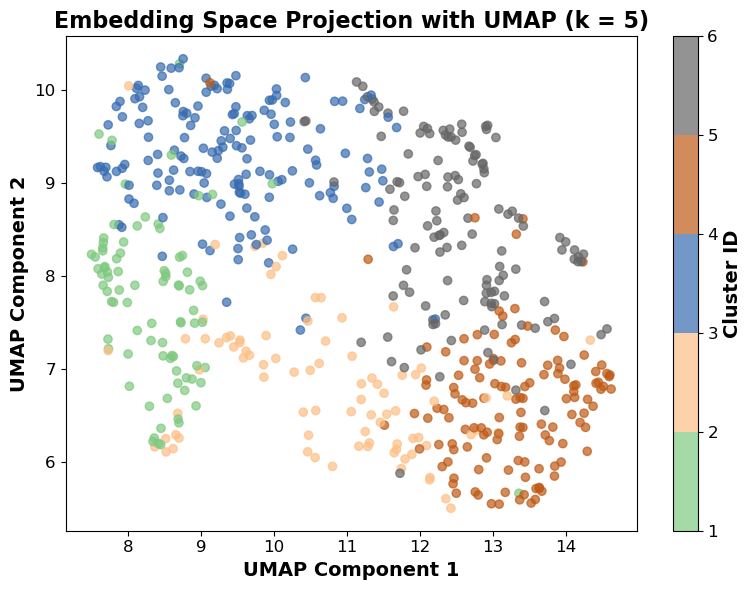


Points are color-coded by cluster, illustrating the semantic separation in embedding space.



In [ ]:
# Set random seed
set_seed(random_seed)

# Part A:Classify each cluster using top keywords and BERT similarity (risk/opportunity)

# Define semantic reference sentences that represent "risk" and "opportunity" clusters
reference_risk = "This topic is about climate-related physical or financial risk."
reference_opportunity = "This topic is about climate-related investment or opportunity."

# Load the sentence-transformer embedding model (same as used during clustering)
semantic_model = SentenceTransformer("all-MiniLM-L6-v2")

# Encode the reference sentences into dense vector representations
risk_vector = semantic_model.encode(reference_risk)
opportunity_vector = semantic_model.encode(reference_opportunity)

# Define cosine similarity function to compare two embedding vectors
def cosine_similarity(vec_a, vec_b):
    return np.dot(vec_a, vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

# Extract top-N keywords per cluster based on frequency of token occurrences
def get_top_cluster_keywords(df, cluster_col, text_col, top_n=5):
    cluster_ids = sorted(df[cluster_col].unique())
    top_keywords_per_cluster = {}
    for c_id in cluster_ids:
        texts_in_cluster = df[df[cluster_col] == c_id][text_col]
        token_list = []
        for doc in texts_in_cluster:
            token_list.extend(re.findall(r'\w+', doc))  # Basic regex-based tokenization
        word_counts = Counter(token_list)
        top_keywords = [w for w, _ in word_counts.most_common(top_n)]
        top_keywords_per_cluster[c_id] = top_keywords
    return top_keywords_per_cluster

# Classify each cluster by comparing its top keywords with reference sentences
def classify_clusters_with_keywords(cluster_keywords):
    cluster_classification = {}
    for cluster_id, keywords in cluster_keywords.items():
        cluster_sentence = " ".join(keywords)
        cluster_vector = semantic_model.encode(cluster_sentence)
        sim_risk = cosine_similarity(cluster_vector, risk_vector)
        sim_opportunity = cosine_similarity(cluster_vector, opportunity_vector)
        # Assign classification based on higher similarity score
        if sim_risk > sim_opportunity:
            cluster_classification[cluster_id] = "RISK"
        else:
            cluster_classification[cluster_id] = "OPPORTUNITY"
    return cluster_classification

# Truncate long text snippets to the first N words for display purposes
def truncate_to_n_words(text, n=20):
    words = text.split()
    if len(words) <= n:
        return text
    return " ".join(words[:n]) + " ..."

# Part B: Build a structured summary table containing cluster metadata and semantic classification

# Compute top keywords for each cluster
top_kwords = get_top_cluster_keywords(df_filtered, "cluster", "processed_text", top_n=5)

# Classify clusters into RISK or OPPORTUNITY based on keyword similarity
cluster_semantics = classify_clusters_with_keywords(top_kwords)

# Build a structured summary for each cluster with keywords, classification, and example snippet
summary_rows = []
for c_id in sorted(top_kwords.keys()):
    snippet = df_filtered[df_filtered["cluster"] == c_id]["processed_text"].iloc[0]
    summary_rows.append({
        "Cluster": c_id,
        "Top Keywords": top_kwords[c_id],
        "Classification": cluster_semantics[c_id],
        "Example Snippet": truncate_to_n_words(snippet, n=20)
    })

# Convert summary rows to a DataFrame
df_summary = pd.DataFrame(summary_rows)

# Format the Keywords column as a comma-separated string with ellipsis
df_summary["Keywords"] = df_summary["Top Keywords"].apply(lambda x: ", ".join(x) + ",...")

# Reorder columns for presentation
df_summary = df_summary[["Cluster", "Keywords", "Classification", "Example Snippet"]]

# Identify the last row to apply bottom border style
split_indices = [len(df_summary) - 1]

# Styling function to apply custom bottom border to the final row
def apply_borders_cluster(row):
    idx = row.name
    border_style = '1px solid black'
    style = [''] * len(row)
    if idx in split_indices:
        style = [f'border-bottom: {border_style}'] * len(row)
    return style

styled_clusters = df_summary.style \
    .set_table_styles([
        {'selector': 'table', 'props': [('border', '1px solid black'), ('border-collapse', 'collapse')]},
        {'selector': 'th', 'props': [
            ('text-align', 'left'),
            ('border-top', '1px solid black'),
            ('border-bottom', '1px solid #999999'),
            ('border-right', '1px solid black'),
            ('border-left', '1px solid black')
        ]},
        {'selector': 'td', 'props': [
            ('text-align', 'left'),
            ('border-right', '1px solid black'),
            ('border-left', '1px solid black')
        ]},
        {'selector': 'td.col3', 'props': [
            ('max-width', '400px'),
            ('overflow', 'hidden'),
            ('text-overflow', 'ellipsis')
        ]}
    ], overwrite=False) \
    .set_properties(**{'text-align': 'left'}) \
    .apply(apply_borders_cluster, axis=1) \
    .hide(axis='index') \
    .set_properties(subset=["Cluster", "Classification"], **{"font-weight": "bold"}) \
    .set_properties(**{"font-size": "14px"}) \
    .set_properties(subset=["Keywords"], **{"font-size": "16px"})


# Display the styled cluster summary table
print("\nSummary of Embedding-Based Clustering Results:\n")
display(styled_clusters)
print("\nEach cluster is represented by its Top Keywords, Classification (RISK or OPPORTUNITY), and a Representative Text Snippet.\n")

# Part C: Visualize the semantic clusters in 2D using UMAP projection

# Reduce document embeddings to 2D using UMAP for visualization
umap_model = UMAP(n_components=2, random_state=random_seed)
embeddings_2d = umap_model.fit_transform(embeddings)

# Retrieve the cluster labels to assign colors
clusters = df_filtered["cluster"].values

# Define a discrete color palette for clusters
cmap = plt.get_cmap("Accent", 5)
norm = BoundaryNorm(boundaries=np.arange(1, 7), ncolors=5)

# Create a scatter plot of documents in UMAP-embedded space, colored by cluster
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=clusters,
    cmap=cmap,
    norm=norm,
    alpha=0.7
)

# Add colorbar with cluster labels
cbar = plt.colorbar(scatter, ticks=np.arange(1, 6))
cbar.set_label("Cluster ID", fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=12)
cbar.ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Add axis labels and title to describe the UMAP projection
plt.title("Embedding Space Projection with UMAP (k = 5)", fontsize=16, fontweight='bold')
plt.xlabel("UMAP Component 1", fontsize=14, fontweight='bold')
plt.ylabel("UMAP Component 2", fontsize=14, fontweight='bold')
plt.tick_params(axis='both', labelsize=12) 
plt.tight_layout()

# Display the UMAP plot
print("\nThe figure below presents a UMAP projection of clustered embeddings based on semantic similarity:\n")
plt.show()
print("\nPoints are color-coded by cluster, illustrating the semantic separation in embedding space.\n")